<a href="https://colab.research.google.com/github/GrigoryBartosh/hse07_nlp/blob/master/3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers

In [0]:
import os
import zipfile

import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from transformers import BertTokenizer, BertModel

from tqdm import tqdm
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.CRITICAL)

PATH_DATASET_1_TEXTS = os.path.join('data', 'train_sentences.txt')
PATH_DATASET_1_TEGS = os.path.join('data', 'train_nes.txt')

PATH_DATASET_2 = os.path.join('data', 'collection5.zip')
DATASET_2_TOKENS_DICT = {'PER': 'PERSON', 'ORG': 'ORG', 'MEDIA': 'ORG'}

PATH_DATASET_TEST = os.path.join('data', 'test.txt')
PATH_RESULTS = os.path.join('data', 'results.txt')

ID_2_TAG = ['PERSON', 'ORG', 'N']
TAG_2_ID = dict((t, i) for i, t in enumerate(ID_2_TAG))

MAX_TEXT_LEN = 512

EPOCHS_1 = 10
EPOCHS_2 = 50
BATCH_SIZE = 32
LEARNING_RATE_1 = 0.0001
LEARNING_RATE_2 = 0.00003
W_L2_NORM = 0.0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
with open(PATH_DATASET_1_TEXTS, 'r') as file:
    dataset_1_texts = file.readlines()
    dataset_1_texts = [' '.join(t.split('\n')) for t in dataset_1_texts]
    dataset_1_texts = [' '.join(t.split()) for t in dataset_1_texts]
    
with open(PATH_DATASET_1_TEGS, 'r') as file:
    dataset_1_tags = file.readlines()
    
for i in range(len(dataset_1_tags)):
    tags = dataset_1_tags[i].split()[:-1]
    tags[::3] = list(map(int, tags[::3]))
    tags[1::3] = list(map(int, tags[1::3]))
    tags = list(zip(tags[::3], tags[1::3], tags[2::3]))
    dataset_1_tags[i] = [(t[0], t[0] + t[1], t[2]) for t in tags]

In [0]:
with zipfile.ZipFile(PATH_DATASET_2) as z:
    filenames = z.namelist()[1:]
    filenames = set([f[:-4] for f in filenames])

    d = DATASET_2_TOKENS_DICT
    dataset_2_texts, dataset_2_tags = [], []
    for filename in filenames:
        with z.open(filename + '.txt', 'r') as file:
            text = file.read().decode('utf8')
        text = ' '.join(text.split('\r'))

        with z.open(filename + '.ann', 'r') as file:
            tags = file.readlines()
            tags = [l.decode('utf8') for l in tags]
            
        tags = [t.split('\t')[1].split() for t in tags]
        tags = [(int(t[1]), int(t[2]), t[0]) for t in tags]
        tags = [(t[0], t[1], t[2]) for t in tags]
        tags = [(t[0], t[1], d[t[2]]) for t in tags if t[2] in d]

        dataset_2_texts.append(text)
        dataset_2_tags.append(tags)

In [0]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-multilingual-cased',
    do_lower_case=False
)

In [0]:
def prepare_sample(text, tags, do_split=False):
    last_i = 0
    data = []
    for s, f, tag in tags:
        if last_i != s and text[last_i:s] != ' ':
            data.append((text[last_i:s], 'N'))
            
        data.append((text[s:f], tag))
        last_i = f
        
    if last_i != len(text):
        data.append((text[last_i:], 'N'))
    
    tokens, labels = [], []
    for s, t in data:
        new_tokens = tokenizer.tokenize(s)
        labels += [t] * len(new_tokens)
        tokens += new_tokens
    
    length = np.random.randint(30, 130)    
    if do_split and len(tokens) > length:
        part_length = length // 3
        stride = 3 * part_length
        nrow = np.ceil(len(tokens) / part_length) - 2
        indexes = part_length * np.arange(nrow)[:, None] + np.arange(stride)
        indexes = indexes.astype(np.int32)

        max_indexe = indexes.max()
        diff = max_indexe + 1 - len(tokens)
        tokens += int(diff > 0) * [tokenizer.sep_token] + \
                  max(0, diff - 1) * [tokenizer.pad_token]
        labels += diff * ['N']

        tokens = np.array(tokens)[indexes].tolist()
        labels = np.array(labels)[indexes].tolist()
    else:
        tokens = [tokens]
        labels = [labels]
        
    for i in range(len(tokens)):
        tokens[i] = [tokenizer.cls_token] + tokens[i]
        labels[i] = ['N'] + labels[i]
        
        if tokens[i][-1] not in [tokenizer.sep_token, tokenizer.pad_token]:
            tokens[i] = tokens[i] + [tokenizer.sep_token]
            labels[i] = labels[i] + ['N']

    return tokens, labels

In [0]:
dataset_tokens, dataset_labels = [], []

for text, tags in zip(dataset_1_texts, dataset_1_tags):
    tokens, labels = prepare_sample(text, tags, do_split=False)
    dataset_tokens += tokens
    dataset_labels += labels
    
for text, tags in zip(dataset_2_texts, dataset_2_tags):
    tokens, labels = prepare_sample(text, tags, do_split=True)
    dataset_tokens += tokens
    dataset_labels += labels
    
x_train, x_val, y_train, y_val = train_test_split(
    dataset_tokens, dataset_labels, test_size=0.1)
train_data = list(zip(x_train, y_train))
val_data = list(zip(x_val, y_val))

In [0]:
def text_collate_fn(texts):
    max_len = max([len(text) for text in texts])
    lens = [text.index(tokenizer.sep_token) + 1 for text in texts]
    masks = [[1] * l + [0] * (max_len - l) for text, l in zip(texts, lens)]
    texts = [text + [tokenizer.pad_token] * (max_len - len(text)) for text in texts]
    texts = [tokenizer.convert_tokens_to_ids(text) for text in texts]
    texts = torch.LongTensor(texts)
    masks = torch.LongTensor(masks)

    return texts, masks

def collate_fn(data):
    texts, labels = zip(*data)

    texts, masks = text_collate_fn(texts)

    max_len = max([len(l) for l in labels])
    labels = [l + ['N'] * (max_len - len(l)) for l in labels]
    labels = [[TAG_2_ID[l] for l in tags] for tags in labels]
    labels = torch.LongTensor(labels)
    
    return texts, masks, labels

train_data_loader = data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)
val_data_loader = data.DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

In [0]:
class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')

        for param in self.bert.parameters():
            param.requires_grad = False

        layers = [
            nn.Linear(768, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(16, 3)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, text, mask):
        x = self.bert(text, attention_mask=mask)[0]
        x = self.layers(x)
        x = x.permute(0, 2, 1)
        return x

In [0]:
def train(model, criterion, optimizer, epochs):
    losses_train = []
    losses_val = []
    for _ in tqdm(range(epochs)):
        losses = []
        model.train()
        for texts, masks, labels in train_data_loader:
            texts = texts.to(device)
            masks = masks.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            ps = model(texts, masks)
            loss = criterion(ps, labels)

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

        losses_train.append(np.array(losses).mean())

        losses = []
        model.eval()
        with torch.no_grad():
            for texts, masks, labels in val_data_loader:
                texts = texts.to(device)
                masks = masks.to(device)
                labels = labels.to(device)
                
                ps = model(texts, masks)
                loss = criterion(ps, labels)

                losses.append(loss.item())

        losses_val.append(np.array(losses).mean())

    plt.plot(range(epochs), losses_train, label="train")
    plt.plot(range(epochs), losses_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

100%|██████████| 10/10 [16:21<00:00, 98.16s/it]


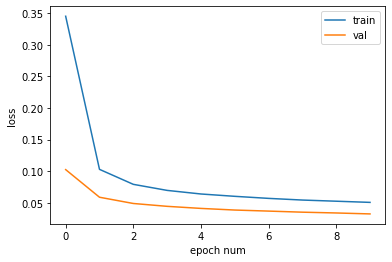

In [13]:
model = TextClassifier()
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    LEARNING_RATE_1,
    weight_decay=W_L2_NORM
)

train(model, criterion, optimizer, EPOCHS_1)

In [0]:
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    LEARNING_RATE_2,
    weight_decay=W_L2_NORM
)

train(model, criterion, metric, optimizer, EPOCHS_2)

In [42]:
with open(PATH_DATASET_TEST, 'r') as file:
    dataset = file.readlines()
    dataset = [' '.join(t.split('\n')) for t in dataset]
    dataset = [' '.join(t.split()) for t in dataset]

for text in dataset:
    prepare_test(text)

'''
res = []
model.eval()
with torch.no_grad():
    while len(dataset) > 0:
        texts, dataset = dataset[:BATCH_SIZE], dataset[BATCH_SIZE:]
        texts, masks = text_collate_fn(texts)
        texts = texts.to(device)
        masks = texts.to(device)

        scores = model(texts, masks)
        scores = scores.cpu().numpy()
        scores = np.around(scores).astype(np.int32) + 1
        res += scores.tolist()

res = '\n'.join([str(x) for x in res])
with open(PATH_RESULTS, 'w') as file:
    file.write(res)
'''

AssertionError: ignored